In [1]:
import warnings
warnings.filterwarnings('ignore')

#import data lib
import numpy as np
import pickle
import itertools

In [2]:
#import sys lib
import os, fnmatch

In [3]:
#import visual lib
import seaborn
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

In [5]:
#import ML lib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib


In [6]:
#random seed
from numpy.random import seed
seed(1)

In [8]:
#import audio lib
import librosa.display, librosa

In [9]:
#configurations
path = './audio'

In [10]:
#Get files 

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))
        
print("found {} audio files in {}".format(len(files), path))

found 4555 audio files in ./audio


In [11]:
#Get lables to identify number of different samples by listing
'''
labels=[]
classes=['cello', 'flute', 'oboe', 'viola', 'sax', 'trumpet']
colour_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
colour_list=[]
for filename in files:
    for name in classes:
        temp = list(filename.split("\\"))
        print(temp)
        if name in temp:
            labels.append(name)
            colour_list.append(colour_dict[name])
            break
        else:
            labels.append('other')

labels=[]
classes=['cello', 'flute', 'oboe', 'viola', 'sax', 'trumpet']
colour_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
colour_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            colour_list.append(colour_dict[name])
            break
        else:
            labels.append('other')
'''

labels=[]
classes=['cello', 'flute', 'oboe', 'viola', 'sax', 'trumpet']
colour_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
colour_list=[]
for filename in files:
    if fnmatch.fnmatchcase(filename, '*'+'cello'+'*'):
            labels.append('cello')
            colour_list.append(colour_dict['cello'])
            #break
    elif fnmatch.fnmatchcase(filename, '*'+'flute'+'*'):
            labels.append('flute')
            colour_list.append(colour_dict['flute'])
            #break
    elif fnmatch.fnmatchcase(filename, '*'+'oboe'+'*'):
            labels.append('oboe')
            colour_list.append(colour_dict['oboe'])
            #break
    elif fnmatch.fnmatchcase(filename, '*'+'viola'+'*'):
            labels.append('viola')
            colour_list.append(colour_dict['viola'])
            #break
    elif fnmatch.fnmatchcase(filename, '*'+'sax'+'*'):
            labels.append('sax')
            colour_list.append(colour_dict['sax'])
            #break
    elif fnmatch.fnmatchcase(filename, '*'+'trumpet'+'*'):
            labels.append('trumpet')
            colour_list.append(colour_dict['trumpet'])
            #break
    else:
            labels.append('other')


In [12]:
print(labels)
print(colour_list)
print(len(colour_list))
import pandas as pd
pd.options.display.max_rows = 50000

['cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 

In [40]:
# Encode labels
labelencoder=LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num=labelencoder.transform(labels)
classes_num.shape[0]

6 classes: cello, flute, oboe, sax, trumpet, viola


4555

In [14]:
# Parameter for MFCC
fs=44100 #sampling frequency
n_fft=2048 #length of FFT window
hop_length=512 #Number of samples between successive frames
n_mels=128 #number of mel bands
n_mfcc=13 #number of MFCCs


In [17]:
#Defining funtion for calculating audio features
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mfcc)
    mfcc=librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector=np.mean(mfcc, 1)
    return feature_vector

In [33]:
# LOADING THEM AND CREATING FEATURES VECTORS (FOR CONFUSION MATRIX)

feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr = fs)
        y/=y.max() #Normalize 
        if len(y) < 2:
            print("error loading %s" %f)
            continue 
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("erroe loading %s. Error: %s" % (f,e))


print("Calculated %d feature vectors" %len(feature_vectors))

get 1 of 4555 = ./audio\cello\cello_A2_025_forte_arco-normal.mp3
get 2 of 4555 = ./audio\cello\cello_A2_025_fortissimo_arco-normal.mp3
get 3 of 4555 = ./audio\cello\cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
get 4 of 4555 = ./audio\cello\cello_A2_025_mezzo-piano_arco-normal.mp3
get 5 of 4555 = ./audio\cello\cello_A2_025_pianissimo_arco-normal.mp3
get 6 of 4555 = ./audio\cello\cello_A2_05_forte_arco-normal.mp3
get 7 of 4555 = ./audio\cello\cello_A2_05_fortissimo_arco-normal.mp3
get 8 of 4555 = ./audio\cello\cello_A2_05_mezzo-piano_arco-normal.mp3
get 9 of 4555 = ./audio\cello\cello_A2_05_pianissimo_arco-normal.mp3
get 10 of 4555 = ./audio\cello\cello_A2_15_forte_arco-normal.mp3
get 11 of 4555 = ./audio\cello\cello_A2_15_pianissimo_arco-normal.mp3
get 12 of 4555 = ./audio\cello\cello_A2_15_piano_arco-normal.mp3
get 13 of 4555 = ./audio\cello\cello_A2_1_forte_arco-normal.mp3
get 14 of 4555 = ./audio\cello\cello_A2_1_fortissimo_arco-normal.mp3
get 15 of 4555 = ./audio\cello\cello_

get 117 of 4555 = ./audio\cello\cello_As4_05_forte_arco-normal.mp3
get 118 of 4555 = ./audio\cello\cello_As4_05_fortissimo_arco-normal.mp3
get 119 of 4555 = ./audio\cello\cello_As4_05_mezzo-piano_arco-normal.mp3
get 120 of 4555 = ./audio\cello\cello_As4_05_pianissimo_arco-normal.mp3
get 121 of 4555 = ./audio\cello\cello_As4_15_forte_arco-normal.mp3
get 122 of 4555 = ./audio\cello\cello_As4_15_fortissimo_arco-normal.mp3
get 123 of 4555 = ./audio\cello\cello_As4_15_mezzo-piano_arco-normal.mp3
get 124 of 4555 = ./audio\cello\cello_As4_15_pianissimo_arco-normal.mp3
get 125 of 4555 = ./audio\cello\cello_As4_1_forte_arco-normal.mp3
get 126 of 4555 = ./audio\cello\cello_As4_1_fortissimo_arco-normal.mp3
get 127 of 4555 = ./audio\cello\cello_As4_1_mezzo-piano_arco-normal.mp3
get 128 of 4555 = ./audio\cello\cello_As4_1_pianissimo_arco-normal.mp3
get 129 of 4555 = ./audio\cello\cello_As4_long_mezzo-forte_arco-harmonic.mp3
get 130 of 4555 = ./audio\cello\cello_As5_025_forte_arco-normal.mp3
get 131

get 234 of 4555 = ./audio\cello\cello_C2_phrase_forte_snap-pizz.mp3
get 235 of 4555 = ./audio\cello\cello_C2_phrase_fortissimo_arco-au-talon.mp3
get 236 of 4555 = ./audio\cello\cello_C2_phrase_fortissimo_arco-sul-ponticello.mp3
get 237 of 4555 = ./audio\cello\cello_C2_phrase_fortissimo_pizz-normal.mp3
get 238 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-forte_arco-col-legno-tratto.mp3
get 239 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-forte_arco-detache.mp3
get 240 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-forte_arco-glissando.mp3
get 241 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-forte_arco-legato.mp3
get 242 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-forte_arco-spiccato.mp3
get 243 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-forte_arco-staccato.mp3
get 244 of 4555 = ./audio\cello\cello_C2_phrase_mezzo-piano_arco-tremolo.mp3
get 245 of 4555 = ./audio\cello\cello_C2_phrase_piano_arco-sul-tasto.mp3
get 246 of 4555 = ./audio\cello\cello_C2_phrase_piano_con-sord.mp3
get 24

get 349 of 4555 = ./audio\cello\cello_Cs3_05_fortissimo_arco-normal.mp3
get 350 of 4555 = ./audio\cello\cello_Cs3_05_pianissimo_arco-normal.mp3
get 351 of 4555 = ./audio\cello\cello_Cs3_05_piano_arco-normal.mp3
get 352 of 4555 = ./audio\cello\cello_Cs3_15_forte_arco-normal.mp3
get 353 of 4555 = ./audio\cello\cello_Cs3_15_fortissimo_arco-normal.mp3
get 354 of 4555 = ./audio\cello\cello_Cs3_15_pianissimo_arco-normal.mp3
get 355 of 4555 = ./audio\cello\cello_Cs3_15_piano_arco-normal.mp3
get 356 of 4555 = ./audio\cello\cello_Cs3_1_forte_arco-normal.mp3
get 357 of 4555 = ./audio\cello\cello_Cs3_1_fortissimo_arco-normal.mp3
get 358 of 4555 = ./audio\cello\cello_Cs3_1_mezzo-piano_non-vibrato.mp3
get 359 of 4555 = ./audio\cello\cello_Cs3_1_pianissimo_arco-normal.mp3
get 360 of 4555 = ./audio\cello\cello_Cs3_1_piano_arco-normal.mp3
get 361 of 4555 = ./audio\cello\cello_Cs4_025_forte_arco-normal.mp3
get 362 of 4555 = ./audio\cello\cello_Cs4_025_fortissimo_arco-normal.mp3
get 363 of 4555 = ./audi

get 465 of 4555 = ./audio\cello\cello_Ds2_025_fortissimo_arco-normal.mp3
get 466 of 4555 = ./audio\cello\cello_Ds2_025_mezzo-forte_arco-col-legno-battuto.mp3
get 467 of 4555 = ./audio\cello\cello_Ds2_025_mezzo-piano_arco-normal.mp3
get 468 of 4555 = ./audio\cello\cello_Ds2_025_pianissimo_arco-normal.mp3
get 469 of 4555 = ./audio\cello\cello_Ds2_05_forte_arco-normal.mp3
get 470 of 4555 = ./audio\cello\cello_Ds2_05_fortissimo_arco-normal.mp3
get 471 of 4555 = ./audio\cello\cello_Ds2_05_pianissimo_arco-normal.mp3
get 472 of 4555 = ./audio\cello\cello_Ds2_05_piano_arco-normal.mp3
get 473 of 4555 = ./audio\cello\cello_Ds2_15_forte_arco-normal.mp3
get 474 of 4555 = ./audio\cello\cello_Ds2_15_fortissimo_arco-normal.mp3
get 475 of 4555 = ./audio\cello\cello_Ds2_15_pianissimo_arco-normal.mp3
get 476 of 4555 = ./audio\cello\cello_Ds2_15_piano_arco-normal.mp3
get 477 of 4555 = ./audio\cello\cello_Ds2_1_forte_arco-normal.mp3
get 478 of 4555 = ./audio\cello\cello_Ds2_1_fortissimo_arco-normal.mp3
ge

get 581 of 4555 = ./audio\cello\cello_E4_1_mezzo-piano_molto-vibrato.mp3
get 582 of 4555 = ./audio\cello\cello_E4_1_pianissimo_arco-normal.mp3
get 583 of 4555 = ./audio\cello\cello_E4_phrase_mezzo-forte_arco-detache.mp3
get 584 of 4555 = ./audio\cello\cello_E4_phrase_mezzo-forte_arco-legato.mp3
get 585 of 4555 = ./audio\cello\cello_E4_phrase_mezzo-forte_arco-spiccato.mp3
get 586 of 4555 = ./audio\cello\cello_E4_phrase_mezzo-forte_arco-staccato.mp3
get 587 of 4555 = ./audio\cello\cello_E5_025_forte_arco-normal.mp3
get 588 of 4555 = ./audio\cello\cello_E5_025_fortissimo_arco-normal.mp3
get 589 of 4555 = ./audio\cello\cello_E5_025_mezzo-piano_arco-normal.mp3
get 590 of 4555 = ./audio\cello\cello_E5_025_pianissimo_arco-normal.mp3
get 591 of 4555 = ./audio\cello\cello_E5_05_forte_arco-normal.mp3
get 592 of 4555 = ./audio\cello\cello_E5_05_fortissimo_arco-normal.mp3
get 593 of 4555 = ./audio\cello\cello_E5_05_mezzo-piano_arco-normal.mp3
get 594 of 4555 = ./audio\cello\cello_E5_05_pianissimo_

get 697 of 4555 = ./audio\cello\cello_Fs2_long_piano_arco-major-trill.mp3
get 698 of 4555 = ./audio\cello\cello_Fs3_025_forte_arco-normal.mp3
get 699 of 4555 = ./audio\cello\cello_Fs3_025_fortissimo_arco-normal.mp3
get 700 of 4555 = ./audio\cello\cello_Fs3_025_mezzo-forte_arco-col-legno-battuto.mp3
get 701 of 4555 = ./audio\cello\cello_Fs3_025_pianissimo_arco-normal.mp3
get 702 of 4555 = ./audio\cello\cello_Fs3_025_piano_arco-normal.mp3
get 703 of 4555 = ./audio\cello\cello_Fs3_05_forte_arco-normal.mp3
get 704 of 4555 = ./audio\cello\cello_Fs3_05_fortissimo_arco-normal.mp3
get 705 of 4555 = ./audio\cello\cello_Fs3_05_mezzo-piano_arco-normal.mp3
get 706 of 4555 = ./audio\cello\cello_Fs3_05_pianissimo_arco-normal.mp3
get 707 of 4555 = ./audio\cello\cello_Fs3_05_piano_arco-normal.mp3
get 708 of 4555 = ./audio\cello\cello_Fs3_15_forte_arco-normal.mp3
get 709 of 4555 = ./audio\cello\cello_Fs3_15_fortissimo_arco-normal.mp3
get 710 of 4555 = ./audio\cello\cello_Fs3_15_pianissimo_arco-normal.m

get 814 of 4555 = ./audio\cello\cello_G5_05_pianissimo_arco-normal.mp3
get 815 of 4555 = ./audio\cello\cello_G5_15_forte_arco-normal.mp3
get 816 of 4555 = ./audio\cello\cello_G5_15_fortissimo_arco-normal.mp3
get 817 of 4555 = ./audio\cello\cello_G5_15_mezzo-piano_arco-normal.mp3
get 818 of 4555 = ./audio\cello\cello_G5_15_pianissimo_arco-normal.mp3
get 819 of 4555 = ./audio\cello\cello_G5_1_forte_arco-normal.mp3
get 820 of 4555 = ./audio\cello\cello_G5_1_fortissimo_arco-normal.mp3
get 821 of 4555 = ./audio\cello\cello_G5_1_mezzo-piano_arco-normal.mp3
get 822 of 4555 = ./audio\cello\cello_G5_1_pianissimo_arco-normal.mp3
get 823 of 4555 = ./audio\cello\cello_Gs2_025_forte_arco-normal.mp3
get 824 of 4555 = ./audio\cello\cello_Gs2_025_fortissimo_arco-normal.mp3
get 825 of 4555 = ./audio\cello\cello_Gs2_025_mezzo-piano_arco-normal.mp3
get 826 of 4555 = ./audio\cello\cello_Gs2_025_pianissimo_arco-normal.mp3
get 827 of 4555 = ./audio\cello\cello_Gs2_05_forte_arco-normal.mp3
get 828 of 4555 = 

get 933 of 4555 = ./audio\flute\flute_A5_1_piano_normal.mp3
get 934 of 4555 = ./audio\flute\flute_A5_long_mezzo-forte_major-trill.mp3
get 935 of 4555 = ./audio\flute\flute_A5_long_mezzo-forte_minor-trill.mp3
get 936 of 4555 = ./audio\flute\flute_A5_long_piano_normal.mp3
get 937 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_double-tonguing.mp3
get 938 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_fluttertonguing.mp3
get 939 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_nonlegato.mp3
get 940 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_staccatissimo.mp3
get 941 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_staccato.mp3
get 942 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_tenuto.mp3
get 943 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_tongued-slur.mp3
get 944 of 4555 = ./audio\flute\flute_A5_phrase_mezzo-forte_triple-tonguing.mp3
get 945 of 4555 = ./audio\flute\flute_A5_very-long_cresc-decresc_normal.mp3
get 946 of 4555 = ./audio\flute\flute_A6

get 1056 of 4555 = ./audio\flute\flute_B5_15_forte_normal.mp3
get 1057 of 4555 = ./audio\flute\flute_B5_15_mezzo-forte_normal.mp3
get 1058 of 4555 = ./audio\flute\flute_B5_15_mezzo-piano_normal.mp3
get 1059 of 4555 = ./audio\flute\flute_B5_15_piano_normal.mp3
get 1060 of 4555 = ./audio\flute\flute_B5_1_forte_normal.mp3
get 1061 of 4555 = ./audio\flute\flute_B5_1_mezzo-forte_normal.mp3
get 1062 of 4555 = ./audio\flute\flute_B5_1_mezzo-piano_normal.mp3
get 1063 of 4555 = ./audio\flute\flute_B5_1_pianissimo_normal.mp3
get 1064 of 4555 = ./audio\flute\flute_B5_1_piano_normal.mp3
get 1065 of 4555 = ./audio\flute\flute_B5_long_piano_normal.mp3
get 1066 of 4555 = ./audio\flute\flute_B6_025_forte_normal.mp3
get 1067 of 4555 = ./audio\flute\flute_B6_025_mezzo-forte_normal.mp3
get 1068 of 4555 = ./audio\flute\flute_B6_025_pianissimo_normal.mp3
get 1069 of 4555 = ./audio\flute\flute_B6_025_piano_normal.mp3
get 1070 of 4555 = ./audio\flute\flute_B6_05_forte_normal.mp3
get 1071 of 4555 = ./audio\fl

get 1179 of 4555 = ./audio\flute\flute_C7_1_mezzo-forte_normal.mp3
get 1180 of 4555 = ./audio\flute\flute_C7_1_pianissimo_normal.mp3
get 1181 of 4555 = ./audio\flute\flute_C7_1_piano_normal.mp3
get 1182 of 4555 = ./audio\flute\flute_C7_very-long_cresc-decresc_normal.mp3
get 1183 of 4555 = ./audio\flute\flute_Cs4_025_forte_normal.mp3
get 1184 of 4555 = ./audio\flute\flute_Cs4_025_mezzo-forte_normal.mp3
get 1185 of 4555 = ./audio\flute\flute_Cs4_025_mezzo-piano_normal.mp3
get 1186 of 4555 = ./audio\flute\flute_Cs4_025_pianissimo_normal.mp3
get 1187 of 4555 = ./audio\flute\flute_Cs4_025_piano_normal.mp3
get 1188 of 4555 = ./audio\flute\flute_Cs4_05_forte_normal.mp3
get 1189 of 4555 = ./audio\flute\flute_Cs4_05_mezzo-forte_normal.mp3
get 1190 of 4555 = ./audio\flute\flute_Cs4_05_mezzo-piano_normal.mp3
get 1191 of 4555 = ./audio\flute\flute_Cs4_05_pianissimo_normal.mp3
get 1192 of 4555 = ./audio\flute\flute_Cs4_05_piano_normal.mp3
get 1193 of 4555 = ./audio\flute\flute_Cs4_15_forte_normal.m

get 1303 of 4555 = ./audio\flute\flute_D5_phrase_mezzo-forte_staccato.mp3
get 1304 of 4555 = ./audio\flute\flute_D5_phrase_mezzo-forte_tenuto.mp3
get 1305 of 4555 = ./audio\flute\flute_D5_phrase_mezzo-forte_tongued-slur.mp3
get 1306 of 4555 = ./audio\flute\flute_D5_phrase_mezzo-forte_triple-tonguing.mp3
get 1307 of 4555 = ./audio\flute\flute_D6_025_forte_normal.mp3
get 1308 of 4555 = ./audio\flute\flute_D6_025_mezzo-forte_normal.mp3
get 1309 of 4555 = ./audio\flute\flute_D6_025_pianissimo_normal.mp3
get 1310 of 4555 = ./audio\flute\flute_D6_025_piano_normal.mp3
get 1311 of 4555 = ./audio\flute\flute_D6_05_forte_normal.mp3
get 1312 of 4555 = ./audio\flute\flute_D6_05_mezzo-forte_normal.mp3
get 1313 of 4555 = ./audio\flute\flute_D6_05_pianissimo_normal.mp3
get 1314 of 4555 = ./audio\flute\flute_D6_05_piano_normal.mp3
get 1315 of 4555 = ./audio\flute\flute_D6_15_forte_normal.mp3
get 1316 of 4555 = ./audio\flute\flute_D6_15_mezzo-forte_normal.mp3
get 1317 of 4555 = ./audio\flute\flute_D6_1

get 1425 of 4555 = ./audio\flute\flute_E4_025_forte_normal.mp3
get 1426 of 4555 = ./audio\flute\flute_E4_025_mezzo-forte_normal.mp3
get 1427 of 4555 = ./audio\flute\flute_E4_025_mezzo-piano_normal.mp3
get 1428 of 4555 = ./audio\flute\flute_E4_025_pianissimo_normal.mp3
get 1429 of 4555 = ./audio\flute\flute_E4_025_piano_normal.mp3
get 1430 of 4555 = ./audio\flute\flute_E4_05_forte_normal.mp3
get 1431 of 4555 = ./audio\flute\flute_E4_05_mezzo-forte_normal.mp3
get 1432 of 4555 = ./audio\flute\flute_E4_05_mezzo-piano_normal.mp3
get 1433 of 4555 = ./audio\flute\flute_E4_05_pianissimo_normal.mp3
get 1434 of 4555 = ./audio\flute\flute_E4_05_piano_normal.mp3
get 1435 of 4555 = ./audio\flute\flute_E4_15_forte_normal.mp3
get 1436 of 4555 = ./audio\flute\flute_E4_15_mezzo-forte_normal.mp3
get 1437 of 4555 = ./audio\flute\flute_E4_15_mezzo-piano_normal.mp3
get 1438 of 4555 = ./audio\flute\flute_E4_15_pianissimo_normal.mp3
get 1439 of 4555 = ./audio\flute\flute_E4_15_piano_normal.mp3
get 1440 of 45

get 1550 of 4555 = ./audio\flute\flute_F6_05_piano_normal.mp3
get 1551 of 4555 = ./audio\flute\flute_F6_15_forte_normal.mp3
get 1552 of 4555 = ./audio\flute\flute_F6_15_mezzo-forte_normal.mp3
get 1553 of 4555 = ./audio\flute\flute_F6_15_pianissimo_normal.mp3
get 1554 of 4555 = ./audio\flute\flute_F6_15_piano_normal.mp3
get 1555 of 4555 = ./audio\flute\flute_F6_1_forte_normal.mp3
get 1556 of 4555 = ./audio\flute\flute_F6_1_mezzo-forte_normal.mp3
get 1557 of 4555 = ./audio\flute\flute_F6_1_pianissimo_normal.mp3
get 1558 of 4555 = ./audio\flute\flute_F6_1_piano_normal.mp3
get 1559 of 4555 = ./audio\flute\flute_F6_long_piano_normal.mp3
get 1560 of 4555 = ./audio\flute\flute_F7_025_forte_normal.mp3
get 1561 of 4555 = ./audio\flute\flute_F7_05_forte_normal.mp3
get 1562 of 4555 = ./audio\flute\flute_F7_15_forte_normal.mp3
get 1563 of 4555 = ./audio\flute\flute_F7_1_forte_normal.mp3
get 1564 of 4555 = ./audio\flute\flute_Fs4_025_forte_normal.mp3
get 1565 of 4555 = ./audio\flute\flute_Fs4_025_m

get 1672 of 4555 = ./audio\flute\flute_G5_15_mezzo-piano_normal.mp3
get 1673 of 4555 = ./audio\flute\flute_G5_15_pianissimo_normal.mp3
get 1674 of 4555 = ./audio\flute\flute_G5_15_piano_normal.mp3
get 1675 of 4555 = ./audio\flute\flute_G5_1_forte_normal.mp3
get 1676 of 4555 = ./audio\flute\flute_G5_1_mezzo-forte_normal.mp3
get 1677 of 4555 = ./audio\flute\flute_G5_1_mezzo-piano_normal.mp3
get 1678 of 4555 = ./audio\flute\flute_G5_1_pianissimo_normal.mp3
get 1679 of 4555 = ./audio\flute\flute_G5_1_piano_normal.mp3
get 1680 of 4555 = ./audio\flute\flute_G5_long_piano_normal.mp3
get 1681 of 4555 = ./audio\flute\flute_G5_phrase_mezzo-forte_double-tonguing.mp3
get 1682 of 4555 = ./audio\flute\flute_G5_phrase_mezzo-forte_fluttertonguing.mp3
get 1683 of 4555 = ./audio\flute\flute_G5_phrase_mezzo-forte_legato.mp3
get 1684 of 4555 = ./audio\flute\flute_G5_phrase_mezzo-forte_staccatissimo.mp3
get 1685 of 4555 = ./audio\flute\flute_G5_phrase_mezzo-forte_staccato.mp3
get 1686 of 4555 = ./audio\flu

get 1797 of 4555 = ./audio\oboe\oboe_A5_1_fortissimo_normal.mp3
get 1798 of 4555 = ./audio\oboe\oboe_A5_1_mezzo-forte_normal.mp3
get 1799 of 4555 = ./audio\oboe\oboe_A5_1_piano_normal.mp3
get 1800 of 4555 = ./audio\oboe\oboe_A5_phrase_mezzo-forte_normal.mp3
get 1801 of 4555 = ./audio\oboe\oboe_A6_025_piano_normal.mp3
get 1802 of 4555 = ./audio\oboe\oboe_A6_05_piano_normal.mp3
get 1803 of 4555 = ./audio\oboe\oboe_A6_15_piano_normal.mp3
get 1804 of 4555 = ./audio\oboe\oboe_A6_1_forte_major-trill.mp3
get 1805 of 4555 = ./audio\oboe\oboe_A6_1_forte_minor-trill.mp3
get 1806 of 4555 = ./audio\oboe\oboe_A6_1_piano_normal.mp3
get 1807 of 4555 = ./audio\oboe\oboe_As3_025_forte_normal.mp3
get 1808 of 4555 = ./audio\oboe\oboe_As3_025_fortissimo_normal.mp3
get 1809 of 4555 = ./audio\oboe\oboe_As3_025_mezzo-forte_normal.mp3
get 1810 of 4555 = ./audio\oboe\oboe_As3_025_piano_normal.mp3
get 1811 of 4555 = ./audio\oboe\oboe_As3_05_forte_normal.mp3
get 1812 of 4555 = ./audio\oboe\oboe_As3_05_fortissimo

get 1925 of 4555 = ./audio\oboe\oboe_C4_025_piano_normal.mp3
get 1926 of 4555 = ./audio\oboe\oboe_C4_05_forte_normal.mp3
get 1927 of 4555 = ./audio\oboe\oboe_C4_05_fortissimo_normal.mp3
get 1928 of 4555 = ./audio\oboe\oboe_C4_05_mezzo-forte_normal.mp3
get 1929 of 4555 = ./audio\oboe\oboe_C4_05_piano_normal.mp3
get 1930 of 4555 = ./audio\oboe\oboe_C4_15_forte_normal.mp3
get 1931 of 4555 = ./audio\oboe\oboe_C4_15_fortissimo_normal.mp3
get 1932 of 4555 = ./audio\oboe\oboe_C4_15_mezzo-forte_normal.mp3
get 1933 of 4555 = ./audio\oboe\oboe_C4_15_piano_normal.mp3
get 1934 of 4555 = ./audio\oboe\oboe_C4_1_forte_normal.mp3
get 1935 of 4555 = ./audio\oboe\oboe_C4_1_fortissimo_normal.mp3
get 1936 of 4555 = ./audio\oboe\oboe_C4_1_mezzo-forte_normal.mp3
get 1937 of 4555 = ./audio\oboe\oboe_C4_1_piano_normal.mp3
get 1938 of 4555 = ./audio\oboe\oboe_C5_025_forte_normal.mp3
get 1939 of 4555 = ./audio\oboe\oboe_C5_025_fortissimo_normal.mp3
get 1940 of 4555 = ./audio\oboe\oboe_C5_025_mezzo-forte_normal.

get 2054 of 4555 = ./audio\oboe\oboe_D6_15_forte_normal.mp3
get 2055 of 4555 = ./audio\oboe\oboe_D6_15_fortissimo_normal.mp3
get 2056 of 4555 = ./audio\oboe\oboe_D6_15_mezzo-forte_normal.mp3
get 2057 of 4555 = ./audio\oboe\oboe_D6_15_piano_normal.mp3
get 2058 of 4555 = ./audio\oboe\oboe_D6_1_forte_major-trill.mp3
get 2059 of 4555 = ./audio\oboe\oboe_D6_1_forte_minor-trill.mp3
get 2060 of 4555 = ./audio\oboe\oboe_D6_1_forte_normal.mp3
get 2061 of 4555 = ./audio\oboe\oboe_D6_1_fortissimo_normal.mp3
get 2062 of 4555 = ./audio\oboe\oboe_D6_1_mezzo-forte_normal.mp3
get 2063 of 4555 = ./audio\oboe\oboe_D6_1_piano_normal.mp3
get 2064 of 4555 = ./audio\oboe\oboe_Ds4_025_forte_normal.mp3
get 2065 of 4555 = ./audio\oboe\oboe_Ds4_025_fortissimo_normal.mp3
get 2066 of 4555 = ./audio\oboe\oboe_Ds4_025_mezzo-forte_normal.mp3
get 2067 of 4555 = ./audio\oboe\oboe_Ds4_025_piano_normal.mp3
get 2068 of 4555 = ./audio\oboe\oboe_Ds4_05_forte_normal.mp3
get 2069 of 4555 = ./audio\oboe\oboe_Ds4_05_fortissimo

get 2183 of 4555 = ./audio\oboe\oboe_F5_025_mezzo-forte_normal.mp3
get 2184 of 4555 = ./audio\oboe\oboe_F5_025_pianissimo_normal.mp3
get 2185 of 4555 = ./audio\oboe\oboe_F5_025_piano_normal.mp3
get 2186 of 4555 = ./audio\oboe\oboe_F5_05_forte_normal.mp3
get 2187 of 4555 = ./audio\oboe\oboe_F5_05_fortissimo_normal.mp3
get 2188 of 4555 = ./audio\oboe\oboe_F5_05_mezzo-forte_normal.mp3
get 2189 of 4555 = ./audio\oboe\oboe_F5_05_piano_normal.mp3
get 2190 of 4555 = ./audio\oboe\oboe_F5_15_forte_normal.mp3
get 2191 of 4555 = ./audio\oboe\oboe_F5_15_fortissimo_normal.mp3
get 2192 of 4555 = ./audio\oboe\oboe_F5_15_mezzo-forte_normal.mp3
get 2193 of 4555 = ./audio\oboe\oboe_F5_15_piano_normal.mp3
get 2194 of 4555 = ./audio\oboe\oboe_F5_1_forte_major-trill.mp3
get 2195 of 4555 = ./audio\oboe\oboe_F5_1_forte_minor-trill.mp3
get 2196 of 4555 = ./audio\oboe\oboe_F5_1_forte_normal.mp3
get 2197 of 4555 = ./audio\oboe\oboe_F5_1_fortissimo_normal.mp3
get 2198 of 4555 = ./audio\oboe\oboe_F5_1_mezzo-forte

get 2310 of 4555 = ./audio\oboe\oboe_G6_05_piano_normal.mp3
get 2311 of 4555 = ./audio\oboe\oboe_G6_15_forte_normal.mp3
get 2312 of 4555 = ./audio\oboe\oboe_G6_15_mezzo-forte_normal.mp3
get 2313 of 4555 = ./audio\oboe\oboe_G6_15_piano_normal.mp3
get 2314 of 4555 = ./audio\oboe\oboe_G6_1_forte_normal.mp3
get 2315 of 4555 = ./audio\oboe\oboe_G6_1_mezzo-forte_normal.mp3
get 2316 of 4555 = ./audio\oboe\oboe_G6_1_piano_normal.mp3
get 2317 of 4555 = ./audio\oboe\oboe_Gs4_025_forte_normal.mp3
get 2318 of 4555 = ./audio\oboe\oboe_Gs4_025_fortissimo_normal.mp3
get 2319 of 4555 = ./audio\oboe\oboe_Gs4_025_mezzo-forte_normal.mp3
get 2320 of 4555 = ./audio\oboe\oboe_Gs4_025_piano_normal.mp3
get 2321 of 4555 = ./audio\oboe\oboe_Gs4_05_forte_normal.mp3
get 2322 of 4555 = ./audio\oboe\oboe_Gs4_05_fortissimo_normal.mp3
get 2323 of 4555 = ./audio\oboe\oboe_Gs4_05_mezzo-forte_normal.mp3
get 2324 of 4555 = ./audio\oboe\oboe_Gs4_05_piano_normal.mp3
get 2325 of 4555 = ./audio\oboe\oboe_Gs4_15_forte_normal.

get 2434 of 4555 = ./audio\sax\saxophone_As3_phrase_mezzo-forte_staccatissimo.mp3
get 2435 of 4555 = ./audio\sax\saxophone_As3_phrase_mezzo-forte_staccato.mp3
get 2436 of 4555 = ./audio\sax\saxophone_As3_phrase_mezzo-forte_tenuto.mp3
get 2437 of 4555 = ./audio\sax\saxophone_As3_phrase_mezzo-forte_tongued-slur.mp3
get 2438 of 4555 = ./audio\sax\saxophone_As4_025_forte_normal.mp3
get 2439 of 4555 = ./audio\sax\saxophone_As4_025_fortissimo_normal.mp3
get 2440 of 4555 = ./audio\sax\saxophone_As4_025_piano_normal.mp3
get 2441 of 4555 = ./audio\sax\saxophone_As4_05_forte_normal.mp3
get 2442 of 4555 = ./audio\sax\saxophone_As4_05_fortissimo_normal.mp3
get 2443 of 4555 = ./audio\sax\saxophone_As4_05_pianissimo_normal.mp3
get 2444 of 4555 = ./audio\sax\saxophone_As4_05_piano_normal.mp3
get 2445 of 4555 = ./audio\sax\saxophone_As4_15_forte_normal.mp3
get 2446 of 4555 = ./audio\sax\saxophone_As4_15_fortissimo_normal.mp3
get 2447 of 4555 = ./audio\sax\saxophone_As4_15_piano_normal.mp3
get 2448 of 

get 2554 of 4555 = ./audio\sax\saxophone_C5_15_piano_normal.mp3
get 2555 of 4555 = ./audio\sax\saxophone_C5_1_forte_normal.mp3
get 2556 of 4555 = ./audio\sax\saxophone_C5_1_fortissimo_normal.mp3
get 2557 of 4555 = ./audio\sax\saxophone_C5_1_mezzo-forte_normal.mp3
get 2558 of 4555 = ./audio\sax\saxophone_C5_1_pianissimo_normal.mp3
get 2559 of 4555 = ./audio\sax\saxophone_C5_1_piano_normal.mp3
get 2560 of 4555 = ./audio\sax\saxophone_C5_long_forte_major-trill.mp3
get 2561 of 4555 = ./audio\sax\saxophone_C5_long_forte_minor-trill.mp3
get 2562 of 4555 = ./audio\sax\saxophone_C5_phrase_mezzo-forte_legato.mp3
get 2563 of 4555 = ./audio\sax\saxophone_C5_phrase_mezzo-forte_nonlegato.mp3
get 2564 of 4555 = ./audio\sax\saxophone_C5_phrase_mezzo-forte_staccatissimo.mp3
get 2565 of 4555 = ./audio\sax\saxophone_C5_phrase_mezzo-forte_staccato.mp3
get 2566 of 4555 = ./audio\sax\saxophone_C5_phrase_mezzo-forte_tongued-slur.mp3
get 2567 of 4555 = ./audio\sax\saxophone_C5_very-long_cresc-decresc_normal.

get 2675 of 4555 = ./audio\sax\saxophone_D6_025_forte_normal.mp3
get 2676 of 4555 = ./audio\sax\saxophone_D6_025_fortissimo_normal.mp3
get 2677 of 4555 = ./audio\sax\saxophone_D6_025_pianissimo_normal.mp3
get 2678 of 4555 = ./audio\sax\saxophone_D6_025_piano_normal.mp3
get 2679 of 4555 = ./audio\sax\saxophone_D6_05_forte_normal.mp3
get 2680 of 4555 = ./audio\sax\saxophone_D6_05_fortissimo_normal.mp3
get 2681 of 4555 = ./audio\sax\saxophone_D6_05_pianissimo_normal.mp3
get 2682 of 4555 = ./audio\sax\saxophone_D6_05_piano_normal.mp3
get 2683 of 4555 = ./audio\sax\saxophone_D6_15_forte_normal.mp3
get 2684 of 4555 = ./audio\sax\saxophone_D6_15_fortissimo_normal.mp3
get 2685 of 4555 = ./audio\sax\saxophone_D6_15_pianissimo_normal.mp3
get 2686 of 4555 = ./audio\sax\saxophone_D6_15_piano_normal.mp3
get 2687 of 4555 = ./audio\sax\saxophone_D6_1_forte_minor-trill.mp3
get 2688 of 4555 = ./audio\sax\saxophone_D6_1_forte_normal.mp3
get 2689 of 4555 = ./audio\sax\saxophone_D6_1_fortissimo_major-tril

get 2794 of 4555 = ./audio\sax\saxophone_E3_phrase_mezzo-forte_nonlegato.mp3
get 2795 of 4555 = ./audio\sax\saxophone_E3_phrase_mezzo-forte_tongued-slur.mp3
get 2796 of 4555 = ./audio\sax\saxophone_E4_025_fortissimo_normal.mp3
get 2797 of 4555 = ./audio\sax\saxophone_E4_025_mezzo-forte_normal.mp3
get 2798 of 4555 = ./audio\sax\saxophone_E4_025_mezzo-forte_slap-tongue.mp3
get 2799 of 4555 = ./audio\sax\saxophone_E4_025_piano_normal.mp3
get 2800 of 4555 = ./audio\sax\saxophone_E4_05_forte_normal.mp3
get 2801 of 4555 = ./audio\sax\saxophone_E4_05_fortissimo_normal.mp3
get 2802 of 4555 = ./audio\sax\saxophone_E4_05_mezzo-forte_normal.mp3
get 2803 of 4555 = ./audio\sax\saxophone_E4_05_pianissimo_normal.mp3
get 2804 of 4555 = ./audio\sax\saxophone_E4_05_pianissimo_subtone.mp3
get 2805 of 4555 = ./audio\sax\saxophone_E4_05_piano_normal.mp3
get 2806 of 4555 = ./audio\sax\saxophone_E4_15_fortissimo_normal.mp3
get 2807 of 4555 = ./audio\sax\saxophone_E4_15_piano_normal.mp3
get 2808 of 4555 = ./a

get 2914 of 4555 = ./audio\sax\saxophone_F5_phrase_mezzo-forte_nonlegato.mp3
get 2915 of 4555 = ./audio\sax\saxophone_F5_phrase_mezzo-forte_staccatissimo.mp3
get 2916 of 4555 = ./audio\sax\saxophone_F5_phrase_mezzo-forte_staccato.mp3
get 2917 of 4555 = ./audio\sax\saxophone_F5_phrase_mezzo-forte_tongued-slur.mp3
get 2918 of 4555 = ./audio\sax\saxophone_F6_025_forte_normal.mp3
get 2919 of 4555 = ./audio\sax\saxophone_F6_025_pianissimo_normal.mp3
get 2920 of 4555 = ./audio\sax\saxophone_F6_025_piano_normal.mp3
get 2921 of 4555 = ./audio\sax\saxophone_F6_05_forte_normal.mp3
get 2922 of 4555 = ./audio\sax\saxophone_F6_05_pianissimo_normal.mp3
get 2923 of 4555 = ./audio\sax\saxophone_F6_05_piano_normal.mp3
get 2924 of 4555 = ./audio\sax\saxophone_F6_15_forte_normal.mp3
get 2925 of 4555 = ./audio\sax\saxophone_F6_15_fortissimo_normal.mp3
get 2926 of 4555 = ./audio\sax\saxophone_F6_15_pianissimo_normal.mp3
get 2927 of 4555 = ./audio\sax\saxophone_F6_15_piano_normal.mp3
get 2928 of 4555 = ./au

get 3034 of 4555 = ./audio\sax\saxophone_G5_05_pianissimo_normal.mp3
get 3035 of 4555 = ./audio\sax\saxophone_G5_05_piano_normal.mp3
get 3036 of 4555 = ./audio\sax\saxophone_G5_15_forte_normal.mp3
get 3037 of 4555 = ./audio\sax\saxophone_G5_15_fortissimo_normal.mp3
get 3038 of 4555 = ./audio\sax\saxophone_G5_15_mezzo-forte_normal.mp3
get 3039 of 4555 = ./audio\sax\saxophone_G5_15_pianissimo_normal.mp3
get 3040 of 4555 = ./audio\sax\saxophone_G5_1_forte_normal.mp3
get 3041 of 4555 = ./audio\sax\saxophone_G5_1_fortissimo_normal.mp3
get 3042 of 4555 = ./audio\sax\saxophone_G5_1_pianissimo_normal.mp3
get 3043 of 4555 = ./audio\sax\saxophone_G5_1_piano_normal.mp3
get 3044 of 4555 = ./audio\sax\saxophone_G6_025_pianissimo_normal.mp3
get 3045 of 4555 = ./audio\sax\saxophone_Gs3_025_forte_normal.mp3
get 3046 of 4555 = ./audio\sax\saxophone_Gs3_025_fortissimo_normal.mp3
get 3047 of 4555 = ./audio\sax\saxophone_Gs3_025_mezzo-piano_normal.mp3
get 3048 of 4555 = ./audio\sax\saxophone_Gs3_05_forte_

get 3152 of 4555 = ./audio\trumpet\trumpet_As3_long_mezzo-piano_normal.mp3
get 3153 of 4555 = ./audio\trumpet\trumpet_As3_long_pianissimo_normal.mp3
get 3154 of 4555 = ./audio\trumpet\trumpet_As3_long_piano_normal.mp3
get 3155 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_double-tonguing.mp3
get 3156 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_fluttertonguing.mp3
get 3157 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_nonlegato.mp3
get 3158 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_staccatissimo.mp3
get 3159 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_staccato.mp3
get 3160 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_tenuto.mp3
get 3161 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_tongued-slur.mp3
get 3162 of 4555 = ./audio\trumpet\trumpet_As3_phrase_mezzo-forte_triple-tonguing.mp3
get 3163 of 4555 = ./audio\trumpet\trumpet_As4_025_forte_normal.mp3
get 3164 of 4555 = ./audio\trumpet\trumpet_As4_025_fo

get 3267 of 4555 = ./audio\trumpet\trumpet_C6_very-long_fortissimo_normal.mp3
get 3268 of 4555 = ./audio\trumpet\trumpet_Cs3_long_pianissimo_normal.mp3
get 3269 of 4555 = ./audio\trumpet\trumpet_Cs4_025_forte_normal.mp3
get 3270 of 4555 = ./audio\trumpet\trumpet_Cs4_025_fortissimo_normal.mp3
get 3271 of 4555 = ./audio\trumpet\trumpet_Cs4_025_pianissimo_normal.mp3
get 3272 of 4555 = ./audio\trumpet\trumpet_Cs4_05_forte_normal.mp3
get 3273 of 4555 = ./audio\trumpet\trumpet_Cs4_05_fortissimo_normal.mp3
get 3274 of 4555 = ./audio\trumpet\trumpet_Cs4_05_pianissimo_normal.mp3
get 3275 of 4555 = ./audio\trumpet\trumpet_Cs4_15_forte_normal.mp3
get 3276 of 4555 = ./audio\trumpet\trumpet_Cs4_15_pianissimo_normal.mp3
get 3277 of 4555 = ./audio\trumpet\trumpet_Cs4_1_forte_normal.mp3
get 3278 of 4555 = ./audio\trumpet\trumpet_Cs4_1_fortissimo_normal.mp3
get 3279 of 4555 = ./audio\trumpet\trumpet_Cs4_1_pianissimo_normal.mp3
get 3280 of 4555 = ./audio\trumpet\trumpet_Cs4_phrase_forte_tremolo.mp3
get 

get 3382 of 4555 = ./audio\trumpet\trumpet_Ds6_1_forte_normal.mp3
get 3383 of 4555 = ./audio\trumpet\trumpet_E2_long_pianissimo_normal.mp3
get 3384 of 4555 = ./audio\trumpet\trumpet_E3_025_mezzo-forte_normal.mp3
get 3385 of 4555 = ./audio\trumpet\trumpet_E3_025_pianissimo_normal.mp3
get 3386 of 4555 = ./audio\trumpet\trumpet_E3_05_forte_normal.mp3
get 3387 of 4555 = ./audio\trumpet\trumpet_E3_05_fortissimo_normal.mp3
get 3388 of 4555 = ./audio\trumpet\trumpet_E3_05_pianissimo_normal.mp3
get 3389 of 4555 = ./audio\trumpet\trumpet_E3_15_forte_normal.mp3
get 3390 of 4555 = ./audio\trumpet\trumpet_E3_15_pianissimo_normal.mp3
get 3391 of 4555 = ./audio\trumpet\trumpet_E3_1_forte_normal.mp3
get 3392 of 4555 = ./audio\trumpet\trumpet_E3_1_fortissimo_normal.mp3
get 3393 of 4555 = ./audio\trumpet\trumpet_E3_1_pianissimo_normal.mp3
get 3394 of 4555 = ./audio\trumpet\trumpet_E3_phrase_cresc-decresc_normal.mp3
get 3395 of 4555 = ./audio\trumpet\trumpet_E3_phrase_forte_minor-trill.mp3
get 3396 of 4

get 3498 of 4555 = ./audio\trumpet\trumpet_G3_025_fortissimo_normal.mp3
get 3499 of 4555 = ./audio\trumpet\trumpet_G3_025_pianissimo_normal.mp3
get 3500 of 4555 = ./audio\trumpet\trumpet_G3_05_forte_normal.mp3
get 3501 of 4555 = ./audio\trumpet\trumpet_G3_05_fortissimo_normal.mp3
get 3502 of 4555 = ./audio\trumpet\trumpet_G3_05_pianissimo_normal.mp3
get 3503 of 4555 = ./audio\trumpet\trumpet_G3_15_forte_normal.mp3
get 3504 of 4555 = ./audio\trumpet\trumpet_G3_15_fortissimo_normal.mp3
get 3505 of 4555 = ./audio\trumpet\trumpet_G3_15_pianissimo_normal.mp3
get 3506 of 4555 = ./audio\trumpet\trumpet_G3_1_forte_normal.mp3
get 3507 of 4555 = ./audio\trumpet\trumpet_G3_1_fortissimo_normal.mp3
get 3508 of 4555 = ./audio\trumpet\trumpet_G3_1_pianissimo_normal.mp3
get 3509 of 4555 = ./audio\trumpet\trumpet_G3_long_mezzo-forte_normal.mp3
get 3510 of 4555 = ./audio\trumpet\trumpet_G3_long_pianissimo_normal.mp3
get 3511 of 4555 = ./audio\trumpet\trumpet_G3_long_piano_normal.mp3
get 3512 of 4555 = .

get 3614 of 4555 = ./audio\viola\viola_A4_1_forte_arco-normal.mp3
get 3615 of 4555 = ./audio\viola\viola_A4_1_fortissimo_arco-normal.mp3
get 3616 of 4555 = ./audio\viola\viola_A4_1_fortissimo_snap-pizz.mp3
get 3617 of 4555 = ./audio\viola\viola_A4_1_mezzo-forte_arco-major-trill.mp3
get 3618 of 4555 = ./audio\viola\viola_A4_1_mezzo-forte_arco-minor-trill.mp3
get 3619 of 4555 = ./audio\viola\viola_A4_1_mezzo-forte_molto-vibrato.mp3
get 3620 of 4555 = ./audio\viola\viola_A4_1_mezzo-piano_non-vibrato.mp3
get 3621 of 4555 = ./audio\viola\viola_A4_1_pianissimo_arco-normal.mp3
get 3622 of 4555 = ./audio\viola\viola_A4_1_piano_arco-glissando.mp3
get 3623 of 4555 = ./audio\viola\viola_A4_1_piano_arco-normal.mp3
get 3624 of 4555 = ./audio\viola\viola_A4_1_piano_pizz-normal.mp3
get 3625 of 4555 = ./audio\viola\viola_A4_phrase_mezzo-forte_arco-detache.mp3
get 3626 of 4555 = ./audio\viola\viola_A4_phrase_mezzo-forte_arco-legato.mp3
get 3627 of 4555 = ./audio\viola\viola_A4_very-long_mezzo-forte_arc

get 3729 of 4555 = ./audio\viola\viola_As6_025_forte_arco-normal.mp3
get 3730 of 4555 = ./audio\viola\viola_As6_025_fortissimo_arco-normal.mp3
get 3731 of 4555 = ./audio\viola\viola_As6_025_pianissimo_arco-normal.mp3
get 3732 of 4555 = ./audio\viola\viola_As6_025_piano_arco-normal.mp3
get 3733 of 4555 = ./audio\viola\viola_As6_05_forte_arco-normal.mp3
get 3734 of 4555 = ./audio\viola\viola_As6_05_fortissimo_arco-normal.mp3
get 3735 of 4555 = ./audio\viola\viola_As6_05_pianissimo_arco-normal.mp3
get 3736 of 4555 = ./audio\viola\viola_As6_05_piano_arco-normal.mp3
get 3737 of 4555 = ./audio\viola\viola_As6_15_forte_arco-normal.mp3
get 3738 of 4555 = ./audio\viola\viola_As6_15_fortissimo_arco-normal.mp3
get 3739 of 4555 = ./audio\viola\viola_As6_1_forte_arco-normal.mp3
get 3740 of 4555 = ./audio\viola\viola_As6_1_fortissimo_arco-normal.mp3
get 3741 of 4555 = ./audio\viola\viola_As6_1_pianissimo_arco-normal.mp3
get 3742 of 4555 = ./audio\viola\viola_As6_1_piano_arco-normal.mp3
get 3743 of 4

get 3843 of 4555 = ./audio\viola\viola_C4_025_piano_arco-normal.mp3
get 3844 of 4555 = ./audio\viola\viola_C4_05_fortissimo_arco-normal.mp3
get 3845 of 4555 = ./audio\viola\viola_C4_05_mezzo-piano_arco-normal.mp3
get 3846 of 4555 = ./audio\viola\viola_C4_05_pianissimo_arco-normal.mp3
get 3847 of 4555 = ./audio\viola\viola_C4_05_piano_arco-normal.mp3
get 3848 of 4555 = ./audio\viola\viola_C4_15_mezzo-piano_arco-normal.mp3
get 3849 of 4555 = ./audio\viola\viola_C4_15_pianissimo_arco-normal.mp3
get 3850 of 4555 = ./audio\viola\viola_C4_1_fortissimo_arco-normal.mp3
get 3851 of 4555 = ./audio\viola\viola_C4_1_fortissimo_pizz-normal.mp3
get 3852 of 4555 = ./audio\viola\viola_C4_1_mezzo-forte_arco-major-trill.mp3
get 3853 of 4555 = ./audio\viola\viola_C4_1_mezzo-forte_arco-minor-trill.mp3
get 3854 of 4555 = ./audio\viola\viola_C4_1_mezzo-forte_molto-vibrato.mp3
get 3855 of 4555 = ./audio\viola\viola_C4_1_mezzo-piano_arco-normal.mp3
get 3856 of 4555 = ./audio\viola\viola_C4_1_mezzo-piano_non-v

get 3958 of 4555 = ./audio\viola\viola_Cs4_1_mezzo-forte_arco-minor-trill.mp3
get 3959 of 4555 = ./audio\viola\viola_Cs4_1_mezzo-forte_molto-vibrato.mp3
get 3960 of 4555 = ./audio\viola\viola_Cs4_1_mezzo-piano_arco-normal.mp3
get 3961 of 4555 = ./audio\viola\viola_Cs4_1_mezzo-piano_non-vibrato.mp3
get 3962 of 4555 = ./audio\viola\viola_Cs4_1_pianissimo_arco-normal.mp3
get 3963 of 4555 = ./audio\viola\viola_Cs4_1_piano_arco-glissando.mp3
get 3964 of 4555 = ./audio\viola\viola_Cs4_1_piano_arco-normal.mp3
get 3965 of 4555 = ./audio\viola\viola_Cs4_1_piano_pizz-normal.mp3
get 3966 of 4555 = ./audio\viola\viola_Cs5_025_forte_arco-normal.mp3
get 3967 of 4555 = ./audio\viola\viola_Cs5_025_fortissimo_arco-normal.mp3
get 3968 of 4555 = ./audio\viola\viola_Cs5_025_pianissimo_arco-normal.mp3
get 3969 of 4555 = ./audio\viola\viola_Cs5_05_forte_arco-normal.mp3
get 3970 of 4555 = ./audio\viola\viola_Cs5_05_fortissimo_arco-normal.mp3
get 3971 of 4555 = ./audio\viola\viola_Cs5_05_mezzo-piano_arco-norm

get 4071 of 4555 = ./audio\viola\viola_D6_025_piano_arco-normal.mp3
get 4072 of 4555 = ./audio\viola\viola_D6_05_forte_arco-normal.mp3
get 4073 of 4555 = ./audio\viola\viola_D6_05_fortissimo_arco-normal.mp3
get 4074 of 4555 = ./audio\viola\viola_D6_05_pianissimo_arco-normal.mp3
get 4075 of 4555 = ./audio\viola\viola_D6_05_piano_arco-normal.mp3
erroe loading ./audio\viola\viola_D6_05_piano_arco-normal.mp3. Error: 
get 4076 of 4555 = ./audio\viola\viola_D6_15_forte_arco-normal.mp3
get 4077 of 4555 = ./audio\viola\viola_D6_1_forte_arco-normal.mp3
get 4078 of 4555 = ./audio\viola\viola_D6_1_fortissimo_arco-normal.mp3
get 4079 of 4555 = ./audio\viola\viola_D6_1_pianissimo_arco-normal.mp3
get 4080 of 4555 = ./audio\viola\viola_D6_1_piano_arco-normal.mp3
get 4081 of 4555 = ./audio\viola\viola_D6_long_mezzo-forte_natural-harmonic.mp3
get 4082 of 4555 = ./audio\viola\viola_D7_15_piano_arco-normal.mp3
get 4083 of 4555 = ./audio\viola\viola_Ds3_025_forte_arco-normal.mp3
get 4084 of 4555 = ./audio

get 4184 of 4555 = ./audio\viola\viola_E4_025_piano_arco-normal.mp3
get 4185 of 4555 = ./audio\viola\viola_E4_05_fortissimo_arco-normal.mp3
get 4186 of 4555 = ./audio\viola\viola_E4_05_mezzo-piano_arco-normal.mp3
get 4187 of 4555 = ./audio\viola\viola_E4_05_pianissimo_arco-normal.mp3
get 4188 of 4555 = ./audio\viola\viola_E4_05_piano_arco-normal.mp3
get 4189 of 4555 = ./audio\viola\viola_E4_15_fortissimo_arco-normal.mp3
get 4190 of 4555 = ./audio\viola\viola_E4_15_mezzo-piano_arco-normal.mp3
get 4191 of 4555 = ./audio\viola\viola_E4_15_pianissimo_arco-normal.mp3
get 4192 of 4555 = ./audio\viola\viola_E4_15_piano_arco-normal.mp3
get 4193 of 4555 = ./audio\viola\viola_E4_1_fortissimo_arco-normal.mp3
get 4194 of 4555 = ./audio\viola\viola_E4_1_mezzo-forte_arco-major-trill.mp3
get 4195 of 4555 = ./audio\viola\viola_E4_1_mezzo-forte_arco-minor-trill.mp3
get 4196 of 4555 = ./audio\viola\viola_E4_1_mezzo-forte_molto-vibrato.mp3
get 4197 of 4555 = ./audio\viola\viola_E4_1_mezzo-piano_arco-norm

get 4298 of 4555 = ./audio\viola\viola_F5_05_mezzo-piano_arco-normal.mp3
get 4299 of 4555 = ./audio\viola\viola_F5_05_pianissimo_arco-normal.mp3
get 4300 of 4555 = ./audio\viola\viola_F5_05_piano_arco-normal.mp3
get 4301 of 4555 = ./audio\viola\viola_F5_15_forte_arco-normal.mp3
get 4302 of 4555 = ./audio\viola\viola_F5_15_fortissimo_arco-normal.mp3
get 4303 of 4555 = ./audio\viola\viola_F5_15_pianissimo_arco-normal.mp3
get 4304 of 4555 = ./audio\viola\viola_F5_1_forte_arco-normal.mp3
get 4305 of 4555 = ./audio\viola\viola_F5_1_fortissimo_arco-normal.mp3
get 4306 of 4555 = ./audio\viola\viola_F5_1_fortissimo_snap-pizz.mp3
get 4307 of 4555 = ./audio\viola\viola_F5_1_mezzo-forte_arco-major-trill.mp3
get 4308 of 4555 = ./audio\viola\viola_F5_1_pianissimo_arco-normal.mp3
get 4309 of 4555 = ./audio\viola\viola_F5_1_piano_arco-normal.mp3
get 4310 of 4555 = ./audio\viola\viola_F6_025_fortissimo_arco-normal.mp3
get 4311 of 4555 = ./audio\viola\viola_F6_025_mezzo-piano_arco-normal.mp3
get 4312 o

get 4413 of 4555 = ./audio\viola\viola_G3_05_piano_arco-normal.mp3
get 4414 of 4555 = ./audio\viola\viola_G3_15_pianissimo_arco-normal.mp3
get 4415 of 4555 = ./audio\viola\viola_G3_15_piano_arco-normal.mp3
get 4416 of 4555 = ./audio\viola\viola_G3_1_fortissimo_arco-normal.mp3
get 4417 of 4555 = ./audio\viola\viola_G3_1_fortissimo_pizz-normal.mp3
get 4418 of 4555 = ./audio\viola\viola_G3_1_mezzo-forte_arco-major-trill.mp3
get 4419 of 4555 = ./audio\viola\viola_G3_1_mezzo-forte_arco-minor-trill.mp3
get 4420 of 4555 = ./audio\viola\viola_G3_1_mezzo-forte_molto-vibrato.mp3
get 4421 of 4555 = ./audio\viola\viola_G3_1_mezzo-piano_non-vibrato.mp3
get 4422 of 4555 = ./audio\viola\viola_G3_1_pianissimo_arco-normal.mp3
get 4423 of 4555 = ./audio\viola\viola_G3_1_piano_arco-normal.mp3
get 4424 of 4555 = ./audio\viola\viola_G3_1_piano_pizz-normal.mp3
get 4425 of 4555 = ./audio\viola\viola_G3_phrase_fortissimo_arco-tremolo.mp3
get 4426 of 4555 = ./audio\viola\viola_G3_phrase_mezzo-forte_arco-detach

get 4528 of 4555 = ./audio\viola\viola_Gs5_025_fortissimo_arco-normal.mp3
get 4529 of 4555 = ./audio\viola\viola_Gs5_025_mezzo-piano_arco-normal.mp3
get 4530 of 4555 = ./audio\viola\viola_Gs5_025_pianissimo_arco-normal.mp3
get 4531 of 4555 = ./audio\viola\viola_Gs5_05_forte_arco-normal.mp3
get 4532 of 4555 = ./audio\viola\viola_Gs5_05_fortissimo_arco-normal.mp3
get 4533 of 4555 = ./audio\viola\viola_Gs5_05_pianissimo_arco-normal.mp3
get 4534 of 4555 = ./audio\viola\viola_Gs5_05_piano_arco-normal.mp3
get 4535 of 4555 = ./audio\viola\viola_Gs5_15_fortissimo_arco-normal.mp3
get 4536 of 4555 = ./audio\viola\viola_Gs5_15_pianissimo_arco-normal.mp3
get 4537 of 4555 = ./audio\viola\viola_Gs5_1_forte_arco-normal.mp3
get 4538 of 4555 = ./audio\viola\viola_Gs5_1_fortissimo_arco-normal.mp3
get 4539 of 4555 = ./audio\viola\viola_Gs5_1_fortissimo_snap-pizz.mp3
get 4540 of 4555 = ./audio\viola\viola_Gs5_1_pianissimo_arco-normal.mp3
get 4541 of 4555 = ./audio\viola\viola_Gs5_1_piano_arco-normal.mp3
g

In [38]:
#NORMALIZATION OF DATASET 

scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:", scaled_feature_vectors.shape)

Feature vectors shape: (4553, 13)


In [39]:
#LOADING MFCC FEATURE 

filename = "mfcc_feature_vectors.p1"
#scaled_feature_vectors = pickle.load( open(filename, "rb"))

# Save feature_vectors for future use 
with open(filename, "wb") as f:
    pickle.dump( scaled_feature_vectors, f)

In [41]:
scaled_feature_vectors.shape[0]

4553

In [43]:
classes_num = np.delete(classes_num, 0)
classes_num.shape[0]

4553

In [44]:
# Machine learning parameters
testset_size = 0.25
n_neighbours = 1

In [45]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
    #print(train_index, test_index)
    #print(splits)
    
for train_index, test_index in splits: 
    train_set = scaled_feature_vectors[train_index] 
    test_set = scaled_feature_vectors[test_index] 
    train_classes = classes_num[train_index] 
    test_classes = classes_num[test_index]
        
        


In [46]:
print("train_set shape: ", train_set.shape)
print("test_set shape: ", test_set.shape)
print("train_classes shape: ", train_classes.shape)
print("test_classes shape: ", test_classes.shape)


train_set shape:  (3414, 13)
test_set shape:  (1139, 13)
train_classes shape:  (3414,)
test_classes shape:  (1139,)


In [162]:
# with n = 1

n_neighbors = 1
model_knn = KNeighborsClassifier(n_neighbors = n_neighbors)
#KNN 
model_knn.fit(train_set, train_classes);
#Predict using the test set 
predicted_labels = model_knn.predict(test_set)

#model_knn.kneighbors_graph(train_set, n_neighbors, mode='connectivity')


In [165]:
#12) EVALUATION

#Recall the ability of the classifier to find all the positive samples 
print("Recall: ", recall_score(test_classes, predicted_labels, average= None))

#Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative 
print("Precision: ", precision_score(test_classes, predicted_labels, average=None))

#F1-Score- The F1 score can be interpreted as a weighted average of the precision and recall
print("F1-Score: ",f1_score(test_classes,predicted_labels,average=None))

#Accuracy - the number of correctly classified samples 
print("Accuracy: %.2f ,"%accuracy_score(test_classes, predicted_labels,normalize = True), accuracy_score(test_classes, predicted_labels, normalize = False))
print("Number of samples: ", test_classes.shape[0])


Recall:  [0.91 0.98 0.94 0.95 0.76 0.94]
Precision:  [0.95 0.95 0.98 0.87 0.88 0.91]
F1-Score:  [0.93 0.96 0.96 0.91 0.81 0.93]
Accuracy: 0.92 , 1053
Number of samples:  1139


In [156]:
#13)VISUALIZATION USING CONFUSION MATRIX

#Compute confusion matraix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

#DEFINING FUNCTION FOR VISUALISING 
def plot_confusion_matrix(cm, classes, normalize =False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalize confusion matrix")
    else:
    print('Confusion matrix, without normalizaton')
    print(cm)
    """
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j], fmt), horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

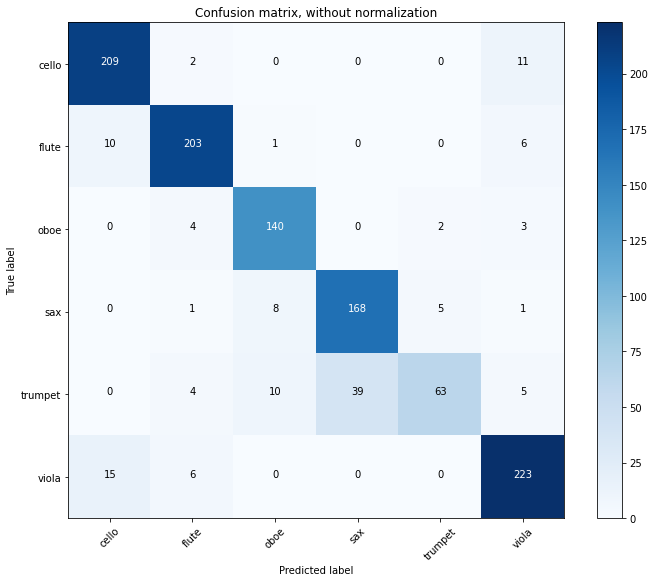

In [157]:
#PLOTING CONFUSION MATRIX 

plt.figure(figsize = (10,8))
plot_confusion_matrix(cnf_matrix, classes = labelencoder.classes_, title="Confusion matrix, without normalization")

Recall:  [0.94 0.92 0.94 0.92 0.52 0.91]
Precision:  [0.89 0.92 0.88 0.81 0.9  0.9 ]
F1-Score:  [0.92 0.92 0.91 0.86 0.66 0.9 ]
Accuracy: 0.88 , 1006
Number of samples:  1139


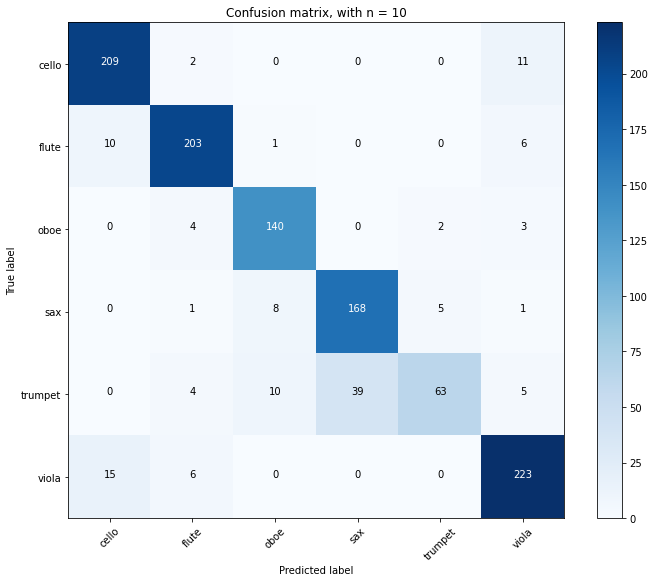

In [158]:
# with n = 10

model_knn = KNeighborsClassifier(n_neighbors = 10)
#KNN 
model_knn.fit(train_set, train_classes);
#Predict using the test set 
predicted_labels = model_knn.predict(test_set)

#Recall the ability of the classifier to find all the positive samples 
print("Recall: ", recall_score(test_classes, predicted_labels, average= None))

#Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative 
print("Precision: ", precision_score(test_classes, predicted_labels, average=None))

#F1-Score- The F1 score can be interpreted as a weighted average of the precision and recall
print("F1-Score: ",f1_score(test_classes,predicted_labels,average=None))

#Accuracy - the number of correctly classified samples 
print("Accuracy: %.2f ,"%accuracy_score(test_classes, predicted_labels,normalize = True), accuracy_score(test_classes, predicted_labels, normalize = False))
print("Number of samples: ", test_classes.shape[0])

cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes, normalize =False, title='Confusion matrix',cmap=plt.cm.Blues):
    """

    if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalize confusion matrix")
    else:
    print('Confusion matrix, without normalizaton')
    print(cm)
    """
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j], fmt), horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
plt.figure(figsize = (10,8))
plot_confusion_matrix(cnf_matrix, classes = labelencoder.classes_, title="Confusion matrix, with n = 10")

Recall:  [0.94 0.95 0.95 0.94 0.69 0.92]
Precision:  [0.91 0.94 0.92 0.88 0.93 0.91]
F1-Score:  [0.92 0.94 0.94 0.91 0.79 0.91]
Accuracy: 0.91 , 1039
Number of samples:  1139


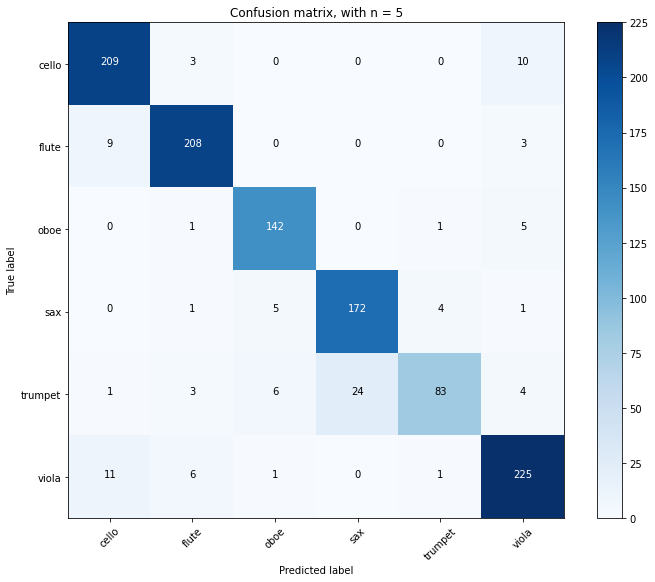

In [159]:
# with n = 5

model_knn = KNeighborsClassifier(n_neighbors = 5)
#KNN 
model_knn.fit(train_set, train_classes);
#Predict using the test set 
predicted_labels = model_knn.predict(test_set)

cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes, normalize =False, title='Confusion matrix',cmap=plt.cm.Blues):
    """

    if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalize confusion matrix")
    else:
    print('Confusion matrix, without normalizaton')
    print(cm)
    """
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j], fmt), horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Recall the ability of the classifier to find all the positive samples 
print("Recall: ", recall_score(test_classes, predicted_labels, average= None))

#Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative 
print("Precision: ", precision_score(test_classes, predicted_labels, average=None))

#F1-Score- The F1 score can be interpreted as a weighted average of the precision and recall
print("F1-Score: ",f1_score(test_classes,predicted_labels,average=None))

#Accuracy - the number of correctly classified samples 
print("Accuracy: %.2f ,"%accuracy_score(test_classes, predicted_labels,normalize = True), accuracy_score(test_classes, predicted_labels, normalize = False))
print("Number of samples: ", test_classes.shape[0])

plt.figure(figsize = (10,8))
plot_confusion_matrix(cnf_matrix, classes = labelencoder.classes_, title="Confusion matrix, with n = 5")